# 1. Setup

## 1-1. Library Setup

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from keras.utils import np_utils
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Input
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.metrics import AUC

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1836454310954298774
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4535020044881194871
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [3]:
!nvidia-smi

Sat Dec 18 04:23:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    34W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 1-2. parameter setup

In [6]:
basemodel = 'Xception'
image_size = 128
image_channels = 3
batch_size = 64
num_epochs = 100
class_num = 3
None_patience_num = 30
imagenet_patience_num = 20
S_all_labels = "S0", "S1", "S2"
T_all_labels = "T0", "T1", "T2"

#base_path = ''
base_path = 'gdrive/My Drive/Research_3_1_1/'

path_data = base_path + 'data_numpy/'
path_model_result = base_path + 'model_result/1 - Base_model_result/' + basemodel + '/'

In [7]:
S_model_name_imagenet = 'S_' + basemodel + '_imagenet'
S_model_name_None = 'S_' + basemodel + '_None'
T_model_name_imagenet = 'T_' + basemodel + '_imagenet'
T_model_name_None = 'T_' + basemodel + '_None'

print(S_model_name_None, S_model_name_imagenet, T_model_name_None, T_model_name_imagenet)

basemodel_list=[S_model_name_imagenet, S_model_name_None, T_model_name_imagenet, T_model_name_None]
basemodel_list

S_Xception_None S_Xception_imagenet T_Xception_None T_Xception_imagenet


['S_Xception_imagenet',
 'S_Xception_None',
 'T_Xception_imagenet',
 'T_Xception_None']

In [8]:
def createDirectory(name): 
    try: 
        if not os.path.exists(name): 
            os.makedirs(path_model_result + name) 
    except OSError: 
        print("Error: Failed to create the directory.")  
        
for i in basemodel_list:
    createDirectory(i)

# 2. Data Load and Image Check

## 2-1. Data Load

In [9]:
xTrain_S = np.load(path_data + 'xTrain_S.npy')
xValid_S = np.load(path_data + 'xValid_S.npy')
xTest_S = np.load(path_data + 'xTest_S.npy')

yTrain_S = np.load(path_data + 'yTrain_S.npy')
yValid_S = np.load(path_data + 'yValid_S.npy')
yTest_S = np.load(path_data + 'yTest_S.npy')

xTrain_T = np.load(path_data + 'xTrain_T.npy')
xValid_T = np.load(path_data + 'xValid_T.npy')
xTest_T = np.load(path_data + 'xTest_T.npy')

yTrain_T = np.load(path_data + 'yTrain_T.npy')
yValid_T = np.load(path_data + 'yValid_T.npy')
yTest_T = np.load(path_data + 'yTest_T.npy')

In [10]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 1)
(640, 128, 128, 3) (640, 1)
(640, 128, 128, 3) (640, 1)

(1440, 128, 128, 3) (1440, 1)
(480, 128, 128, 3) (480, 1)
(480, 128, 128, 3) (480, 1)


In [11]:
xTrain_S = xTrain_S.astype('float32')/255
xValid_S = xValid_S.astype('float32')/255
xTest_S = xTest_S.astype('float32')/255

yTrain_S = np_utils.to_categorical(yTrain_S, class_num)
yValid_S = np_utils.to_categorical(yValid_S, class_num)
yTest_S = np_utils.to_categorical(yTest_S, class_num)

xTrain_T = xTrain_T.astype('float32')/255
xValid_T = xValid_T.astype('float32')/255
xTest_T = xTest_T.astype('float32')/255

yTrain_T = np_utils.to_categorical(yTrain_T, class_num)
yValid_T = np_utils.to_categorical(yValid_T, class_num)
yTest_T = np_utils.to_categorical(yTest_T, class_num)

In [12]:
print(xTrain_S.shape, yTrain_S.shape)
print(xValid_S.shape, yValid_S.shape)
print(xTest_S.shape, yTest_S.shape)
print()
print(xTrain_T.shape, yTrain_T.shape)
print(xValid_T.shape, yValid_T.shape)
print(xTest_T.shape, yTest_T.shape)

(1920, 128, 128, 3) (1920, 3)
(640, 128, 128, 3) (640, 3)
(640, 128, 128, 3) (640, 3)

(1440, 128, 128, 3) (1440, 3)
(480, 128, 128, 3) (480, 3)
(480, 128, 128, 3) (480, 3)


## 2-2. Image Check

xTrain_S image Numbers :  1920
xTrain_S image Numbers // 10 :  192
10


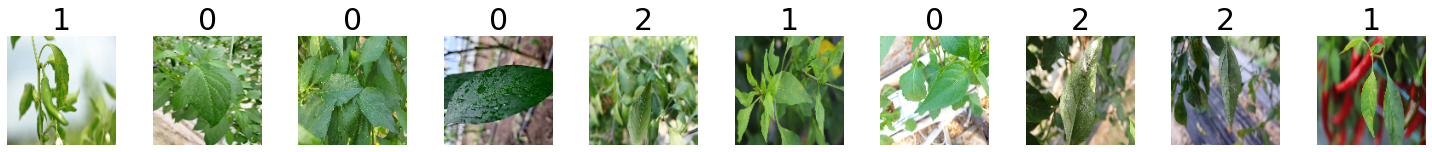

In [13]:
temp_S_a = len(xTrain_S)
print("xTrain_S image Numbers : ", temp_S_a)
temp_S_b = temp_S_a//10
print("xTrain_S image Numbers // 10 : ", temp_S_b)
temp_S_c = 0
for i in range(0, temp_S_a, temp_S_b):
    temp_S_c += 1
print(temp_S_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0, temp_S_a, temp_S_b):
    plt.subplot(1, temp_S_c, c+1)
    plt.imshow(xTrain_S[i])
    plt.title(yTrain_S[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

xTrain_S image Numbers :  1440
xTrain_S image Numbers // 10 :  144
10


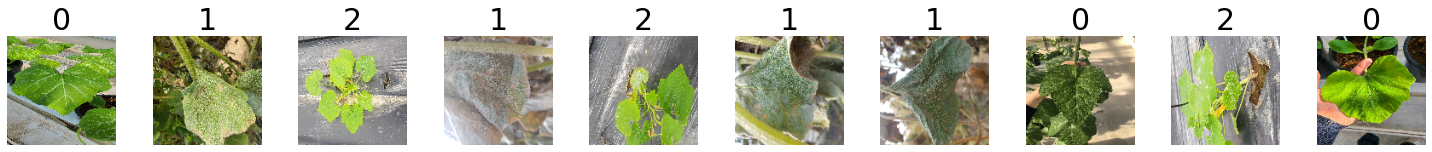

In [14]:
temp_T_a = len(xTrain_T)
print("xTrain_S image Numbers : ", temp_T_a)
temp_T_b = temp_T_a//10
print("xTrain_S image Numbers // 10 : ", temp_T_b)
temp_T_c = 0
for i in range(0, temp_T_a, temp_T_b):
    temp_T_c += 1
print(temp_T_c)


c=0
plt.figure(figsize=(20,3))
for i in range(0,temp_T_a,temp_T_b):
    plt.subplot(1, temp_T_c, c+1)
    plt.imshow(xTrain_T[i])
    plt.title(yTrain_T[i].argmax(),fontsize=30)
    plt.tight_layout()
    plt.axis('off')
    c+=1
plt.show()

# 3. Network Setting and Training

## 3-1. Network Setting

In [15]:
def feature_extractor_None(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights=None, input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_None(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_None():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_None(inp)
    classifier_output = classifier_None(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [16]:
def feature_extractor_imagenet(inp):
    base_model=tf.keras.applications.Xception (
                include_top=False, weights='imagenet', input_tensor=inp)
    input = base_model.input
    out = base_model.layers[-1].output
    feature_output = tf.keras.layers.GlobalAveragePooling2D(name='feature')(out)
    return feature_output


def classifier_imagenet(feature_output):
    out = feature_output
    out = Dense(128, activation="relu")(out)
    out = Dense(32, activation="relu")(out)
    classifier_output = Dense(class_num, activation="softmax", name="classifier_output")(out)
    return classifier_output


def model_imagenet():
    inp = Input(shape=(image_size, image_size, image_channels))   
    feature_output = feature_extractor_imagenet(inp)
    classifier_output = classifier_imagenet(feature_output)
    model = Model(inputs=inp, outputs=classifier_output)
    return model

In [17]:
#plot_model(model_None())
#plot_model(model_imagenet())

## 3-2. Source Domain Training - weights=None

In [18]:
S_basemodel_None=model_None()
#S_basemodel_None.summary()

In [19]:
S_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

S_basemodel_None_main =S_basemodel_None.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 23s 296ms/step - loss: 0.7296 - accuracy: 0.6828 - val_loss: 1.0932 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 8s 251ms/step - loss: 0.4283 - accuracy: 0.8495 - val_loss: 1.0928 - val_accuracy: 0.5000
Epoch 3/100
30/30 [==============================] - 8s 251ms/step - loss: 0.2686 - accuracy: 0.9005 - val_loss: 1.0921 - val_accuracy: 0.2500
Epoch 4/100
30/30 [==============================] - 8s 251ms/step - loss: 0.2158 - accuracy: 0.9198 - val_loss: 1.0806 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 8s 251ms/step - loss: 0.1861 - accuracy: 0.9323 - val_loss: 1.0880 - val_accuracy: 0.2500
Epoch 6/100
30/30 [==============================] - 8s 251ms/step - loss: 0.1776 - accuracy: 0.9359 - val_loss: 1.0943 - val_accuracy: 0.2500
Epoch 7/100
30/30 [==============================] - 8s 252ms/step - loss: 0.1138 - accuracy: 0.9599 - val_loss: 1.1658 - val_accuracy: 0.250

In [20]:
S_basemodel_None_df = pd.DataFrame(S_basemodel_None_main.history)
S_basemodel_None_df.to_csv( path_model_result + S_model_name_None + '/' + S_model_name_None + '_df.csv' )
S_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.729553,0.682813,1.093154,0.500000
1,0.428331,0.849479,1.092817,0.500000
2,0.268568,0.900521,1.092086,0.250000
3,0.215800,0.919792,1.080576,0.500000
4,0.186053,0.932292,1.087959,0.250000
...,...,...,...,...
57,0.004498,0.998958,0.590759,0.896875
58,0.015812,0.993229,1.334842,0.804688
59,0.031749,0.991146,1.236111,0.835938
60,0.028128,0.991146,5.436620,0.437500


Minimum validation loss: 0.38592982292175293
Maximum validation accuracy: 0.926562488079071


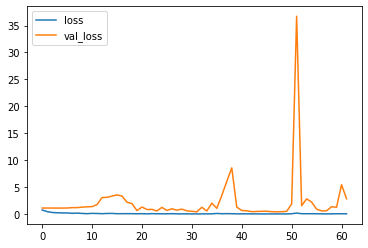

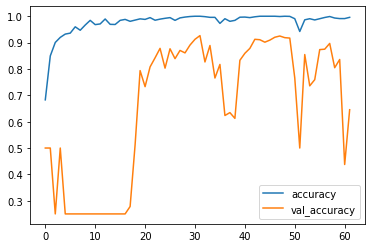

In [21]:
S_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_loss,val_loss.png')
S_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_None + '/' + S_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_None_df['val_accuracy'].max()))

In [22]:
print("Evaluate on test data")
S_basemodel_None_results = S_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_basemodel_None_results)

Evaluate on test data
20/20 [==============================] - 2s 30ms/step - loss: 0.2897 - accuracy: 0.9266
test loss, test acc: [0.28970518708229065, 0.926562488079071]


In [23]:
S_basemodel_None_pred_Y = S_basemodel_None.predict(xTest_S, verbose = True)

20/20 [==============================] - 1s 26ms/step


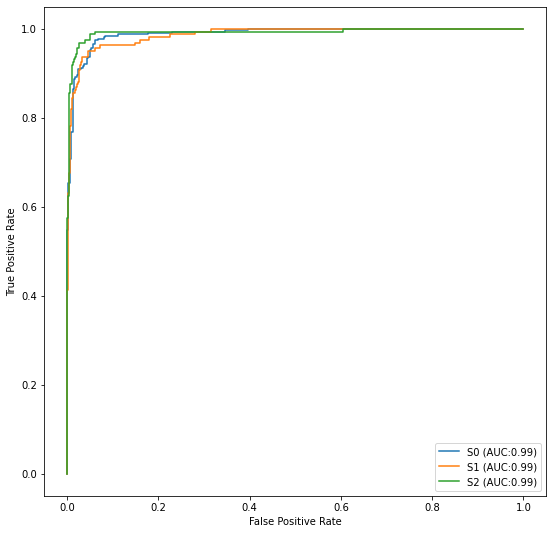

In [24]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_None + '/' + S_model_name_None +'_TESTSET_AUC.png' )

## 3-3. Source Domain Training - weights='imagenet'

In [25]:
S_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

83697664/83683744 [==============================] - 1s 0us/step


In [26]:
S_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

S_basemodel_imagenet_main =S_basemodel_imagenet.fit(xTrain_S, yTrain_S, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_S, yValid_S), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(S_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
30/30 [==============================] - 14s 292ms/step - loss: 0.4545 - accuracy: 0.8271 - val_loss: 18.1709 - val_accuracy: 0.5000
Epoch 2/100
30/30 [==============================] - 8s 256ms/step - loss: 0.1015 - accuracy: 0.9615 - val_loss: 8.0925 - val_accuracy: 0.6484
Epoch 3/100
30/30 [==============================] - 8s 255ms/step - loss: 0.0912 - accuracy: 0.9750 - val_loss: 3.4931 - val_accuracy: 0.7734
Epoch 4/100
30/30 [==============================] - 8s 255ms/step - loss: 0.0673 - accuracy: 0.9797 - val_loss: 2.1589 - val_accuracy: 0.8156
Epoch 5/100
30/30 [==============================] - 8s 256ms/step - loss: 0.0357 - accuracy: 0.9885 - val_loss: 0.9205 - val_accuracy: 0.9156
Epoch 6/100
30/30 [==============================] - 8s 252ms/step - loss: 0.0498 - accuracy: 0.9875 - val_loss: 1.0885 - val_accuracy: 0.8453
Epoch 7/100
30/30 [==============================] - 8s 252ms/step - loss: 0.0678 - accuracy: 0.9812 - val_loss: 0.8326 - val_accuracy: 0.87

In [27]:
S_basemodel_imagenet_df = pd.DataFrame(S_basemodel_imagenet_main.history)
S_basemodel_imagenet_df.to_csv( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_df.csv' )
S_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.454536,0.827083,18.170877,0.500000
1,0.101455,0.961458,8.092505,0.648438
2,0.091186,0.975000,3.493095,0.773438
3,0.067293,0.979688,2.158900,0.815625
4,0.035657,0.988542,0.920509,0.915625
5,0.049755,0.987500,1.088474,0.845312
6,0.067815,0.981250,0.832605,0.875000
7,0.041067,0.986979,0.178433,0.965625
8,0.042192,0.989583,0.351411,0.931250
9,0.027375,0.990104,0.275816,0.953125


Minimum validation loss: 0.06525532156229019
Maximum validation accuracy: 0.9781249761581421


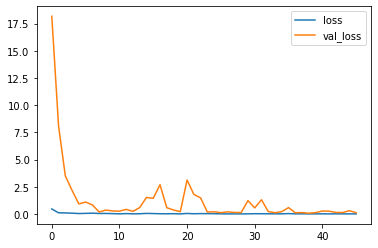

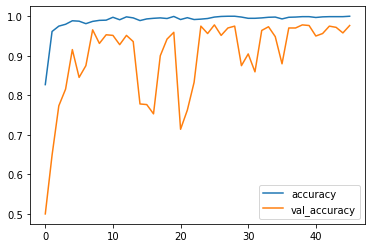

In [28]:
S_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_loss,val_loss.png')
S_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(S_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(S_basemodel_imagenet_df['val_accuracy'].max()))

In [29]:
print("Evaluate on test data")
S_model_name_imagenet_results = S_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", S_model_name_imagenet_results)

Evaluate on test data
20/20 [==============================] - 1s 30ms/step - loss: 0.0827 - accuracy: 0.9750
test loss, test acc: [0.0826820582151413, 0.9750000238418579]


In [30]:
S_model_name_imagenet_pred_Y = S_basemodel_imagenet.predict(xTest_S, verbose = True)

20/20 [==============================] - 1s 26ms/step


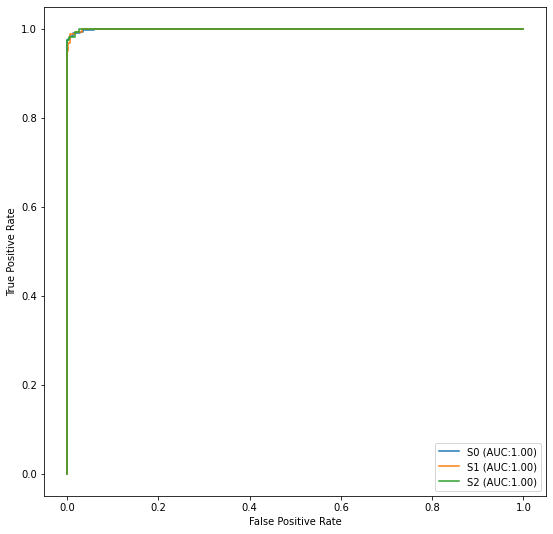

In [31]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(S_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_S[:,idx].astype(int), S_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet +'_TESTSET_AUC.png' )

## 3-4. Target Domain Training - weights=None

In [32]:
T_basemodel_None=model_None()
#S_basemodel_None.summary()

In [33]:
T_basemodel_None.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=None_patience_num, restore_best_weights=True)

T_basemodel_None_main =T_basemodel_None.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_None_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 12s 315ms/step - loss: 0.4602 - accuracy: 0.8271 - val_loss: 1.1002 - val_accuracy: 0.2500
Epoch 2/100
23/23 [==============================] - 6s 253ms/step - loss: 0.2116 - accuracy: 0.9417 - val_loss: 1.0946 - val_accuracy: 0.5000
Epoch 3/100
23/23 [==============================] - 6s 247ms/step - loss: 0.1481 - accuracy: 0.9563 - val_loss: 1.0964 - val_accuracy: 0.2500
Epoch 4/100
23/23 [==============================] - 6s 248ms/step - loss: 0.1490 - accuracy: 0.9535 - val_loss: 1.0894 - val_accuracy: 0.5000
Epoch 5/100
23/23 [==============================] - 6s 248ms/step - loss: 0.0887 - accuracy: 0.9722 - val_loss: 1.0827 - val_accuracy: 0.5000
Epoch 6/100
23/23 [==============================] - 6s 248ms/step - loss: 0.0840 - accuracy: 0.9785 - val_loss: 1.0749 - val_accuracy: 0.5000
Epoch 7/100
23/23 [==============================] - 6s 248ms/step - loss: 0.0598 - accuracy: 0.9812 - val_loss: 1.0721 - val_accuracy: 0.500

In [34]:
T_basemodel_None_df = pd.DataFrame(T_basemodel_None_main.history)
T_basemodel_None_df.to_csv( path_model_result + T_model_name_None + '/' + T_model_name_None + '_df.csv' )
T_basemodel_None_df

,loss,accuracy,val_loss,val_accuracy
0,0.460189,0.827083,1.100168,0.250000
1,0.211578,0.941667,1.094637,0.500000
2,0.148135,0.956250,1.096361,0.250000
3,0.149004,0.953472,1.089359,0.500000
4,0.088676,0.972222,1.082653,0.500000
...,...,...,...,...
70,0.000194,1.000000,0.189491,0.960417
71,0.000019,1.000000,0.206534,0.962500
72,0.000031,1.000000,0.195415,0.962500
73,0.000033,1.000000,0.187651,0.962500


Minimum validation loss: 0.14832180738449097
Maximum validation accuracy: 0.96875


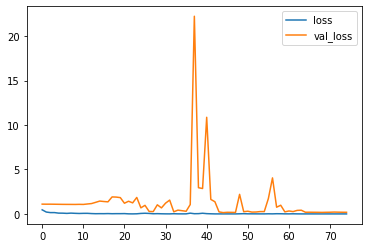

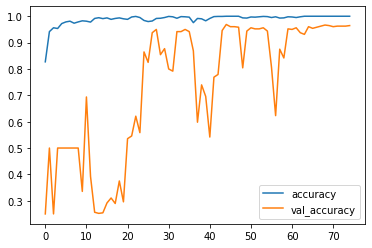

In [35]:
T_basemodel_None_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_loss,val_loss.png')
T_basemodel_None_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_None + '/' + T_model_name_None + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_None_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_None_df['val_accuracy'].max()))

In [36]:
print("Evaluate on test data")
T_basemodel_None_results = T_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_basemodel_None_results)

Evaluate on test data
15/15 [==============================] - 1s 29ms/step - loss: 0.0596 - accuracy: 0.9812
test loss, test acc: [0.0596020445227623, 0.981249988079071]


In [37]:
T_basemodel_None_pred_Y = T_basemodel_None.predict(xTest_T, verbose = True)

15/15 [==============================] - 1s 26ms/step


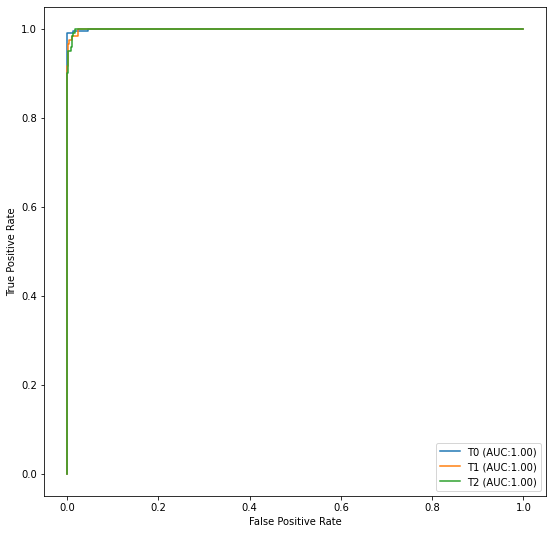

In [38]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_basemodel_None_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_None + '/' + T_model_name_None + '_TESTSET_AUC.png' )

## 3-5. Target Domain Training - weights='imagenet'

In [39]:
T_basemodel_imagenet=model_imagenet()
#S_basemodel_None.summary()

In [40]:
T_basemodel_imagenet.compile(optimizer='adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=imagenet_patience_num, restore_best_weights=True)

T_basemodel_imagenet_main =T_basemodel_imagenet.fit(xTrain_T, yTrain_T, 
                    epochs=num_epochs, batch_size=batch_size, validation_data=(xValid_T, yValid_T), callbacks=[ES])


print( "Maximal validation accuracy: {:.2f}%".format(
        max(T_basemodel_imagenet_main.history["val_accuracy"]) * 100))

Epoch 1/100
23/23 [==============================] - 12s 300ms/step - loss: 0.3237 - accuracy: 0.9021 - val_loss: 14.9146 - val_accuracy: 0.7042
Epoch 2/100
23/23 [==============================] - 6s 248ms/step - loss: 0.0472 - accuracy: 0.9840 - val_loss: 3.6923 - val_accuracy: 0.4875
Epoch 3/100
23/23 [==============================] - 6s 253ms/step - loss: 0.0252 - accuracy: 0.9903 - val_loss: 9.5025 - val_accuracy: 0.7250
Epoch 4/100
23/23 [==============================] - 6s 247ms/step - loss: 0.0458 - accuracy: 0.9833 - val_loss: 42.2476 - val_accuracy: 0.6062
Epoch 5/100
23/23 [==============================] - 6s 253ms/step - loss: 0.0293 - accuracy: 0.9924 - val_loss: 3.1378 - val_accuracy: 0.8938
Epoch 6/100
23/23 [==============================] - 6s 253ms/step - loss: 0.0239 - accuracy: 0.9896 - val_loss: 0.4214 - val_accuracy: 0.9667
Epoch 7/100
23/23 [==============================] - 6s 248ms/step - loss: 0.0423 - accuracy: 0.9903 - val_loss: 2.3271 - val_accuracy: 0.9

In [41]:
T_basemodel_imagenet_df = pd.DataFrame(T_basemodel_imagenet_main.history)
T_basemodel_imagenet_df.to_csv( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_df.csv' )
T_basemodel_imagenet_df

,loss,accuracy,val_loss,val_accuracy
0,0.323739,0.902083,14.914629,0.704167
1,0.047228,0.984028,3.692264,0.487500
2,0.025246,0.990278,9.502536,0.725000
3,0.045800,0.983333,42.247555,0.606250
4,0.029262,0.992361,3.137849,0.893750
5,0.023856,0.989583,0.421448,0.966667
6,0.042280,0.990278,2.327084,0.902083
7,0.013228,0.995833,0.673100,0.941667
8,0.045042,0.994444,0.130357,0.987500
9,0.043868,0.985417,0.327948,0.931250


Minimum validation loss: 0.009543705731630325
Maximum validation accuracy: 0.9958333373069763


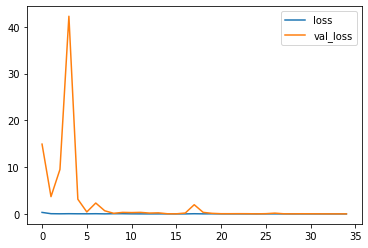

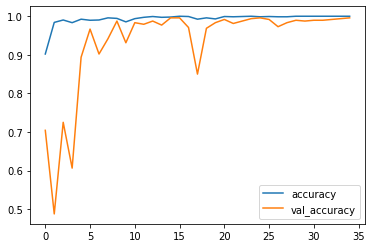

In [42]:
T_basemodel_imagenet_df.loc[:, ['loss', 'val_loss']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_loss,val_loss.png')
T_basemodel_imagenet_df.loc[:, ['accuracy', 'val_accuracy']].plot();
plt.savefig(path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_accuracy,val_accuracy.png')
print("Minimum validation loss: {}".format(T_basemodel_imagenet_df['val_loss'].min()))
print("Maximum validation accuracy: {}".format(T_basemodel_imagenet_df['val_accuracy'].max()))

In [43]:
print("Evaluate on test data")
T_model_name_imagenet_results = T_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", T_model_name_imagenet_results)

Evaluate on test data
15/15 [==============================] - 1s 29ms/step - loss: 0.0097 - accuracy: 0.9979
test loss, test acc: [0.009733149781823158, 0.9979166388511658]


In [44]:
T_model_name_imagenet_pred_Y = T_basemodel_imagenet.predict(xTest_T, verbose = True)

15/15 [==============================] - 1s 26ms/step


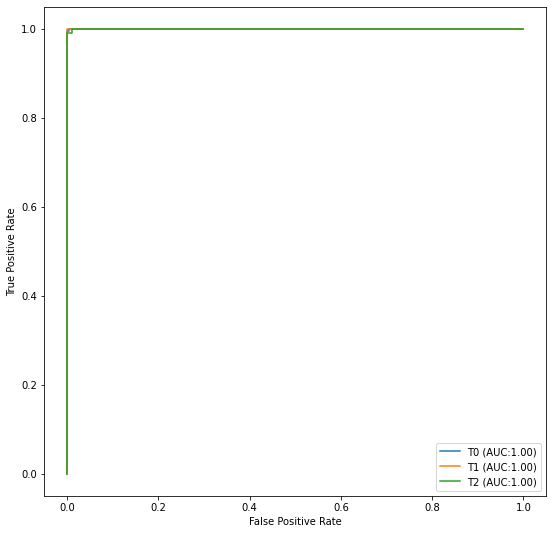

In [45]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(T_all_labels):
    fpr, tpr, thresholds = roc_curve(yTest_T[:,idx].astype(int), T_model_name_imagenet_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '_TESTSET_AUC.png' )

# 4. Result Report

In [46]:
print(S_model_name_None)
print("test loss, test acc:", S_basemodel_None_results)

S_Xception_None
test loss, test acc: [0.28970518708229065, 0.926562488079071]


In [47]:
print(S_model_name_imagenet)
print("test loss, test acc:", S_model_name_imagenet_results)

S_Xception_imagenet
test loss, test acc: [0.0826820582151413, 0.9750000238418579]


In [48]:
print(T_model_name_None)
print("test loss, test acc:", T_basemodel_None_results)

T_Xception_None
test loss, test acc: [0.0596020445227623, 0.981249988079071]


In [49]:
print(T_model_name_imagenet)
print("test loss, test acc:", T_model_name_imagenet_results)

T_Xception_imagenet
test loss, test acc: [0.009733149781823158, 0.9979166388511658]


# 5. Source Domain Training Model ↔ Target Domain Training Model 상호 Test Data Set 평가 

In [50]:
print( S_model_name_None + " →→→ Target Test")
S_basemodel_None_results_T = S_basemodel_None.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_basemodel_None_results_T)

S_Xception_None →→→ Target Test
15/15 [==============================] - 0s 29ms/step - loss: 4.7664 - accuracy: 0.4625
test loss, test acc: [4.766386032104492, 0.4625000059604645]


In [51]:
print( S_model_name_imagenet + " →→→ Target Test")
S_model_name_imagenet_results_T = S_basemodel_imagenet.evaluate(xTest_T, yTest_T)
print("test loss, test acc:", S_model_name_imagenet_results_T)

S_Xception_imagenet →→→ Target Test
15/15 [==============================] - 0s 29ms/step - loss: 3.7117 - accuracy: 0.5333
test loss, test acc: [3.711719512939453, 0.5333333611488342]


In [52]:
print( T_model_name_None + " →→→ Source Test")
T_basemodel_None_results_S = T_basemodel_None.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_basemodel_None_results_S)

T_Xception_None →→→ Source Test
20/20 [==============================] - 1s 29ms/step - loss: 5.7046 - accuracy: 0.4359
test loss, test acc: [5.704638481140137, 0.4359374940395355]


In [53]:
print( T_model_name_imagenet + " →→→ Source Test")
T_model_name_imagenet_results_S = T_basemodel_imagenet.evaluate(xTest_S, yTest_S)
print("test loss, test acc:", T_model_name_imagenet_results_S)

T_Xception_imagenet →→→ Source Test
20/20 [==============================] - 1s 29ms/step - loss: 5.1950 - accuracy: 0.4313
test loss, test acc: [5.195005893707275, 0.4312500059604645]


# 6. Model Save 

In [54]:
S_basemodel_None.save( path_model_result + S_model_name_None + '/' + S_model_name_None + '.h5' )
S_basemodel_imagenet.save( path_model_result + S_model_name_imagenet + '/' + S_model_name_imagenet + '.h5' )
T_basemodel_None.save( path_model_result + T_model_name_None + '/' + T_model_name_None + '.h5' )
T_basemodel_imagenet.save( path_model_result + T_model_name_imagenet + '/' + T_model_name_imagenet + '.h5' )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
